In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9188957149432234
0.8698779253276527
0.7566336743301856
1.191342712629197
0.9953424146502148


In [8]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'SCHD', 'SPY', 'DVY', 'TLT', 'JEPQ']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  6 of 6 completed


In [9]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'S&P500', 'SPY')
df_imp = myfuncs.imputation(df_imp, 'Div', 'SCHD')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')


## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.044886410197329
0.9936268057888953
0.9954511450159806
-0.41935422549060514


In [10]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Visualization

In [11]:
assets = ['JEPQ', 'QQQ']
## assets = ['SCHD', 'QQQ']

In [14]:
plot_df = df_imp['1999':]
plot_df = df_imp['1999':'2007']
# plot_df = df_imp['2007':]
plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]
highlight_periods = [
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

<Axes: xlabel='Date'>

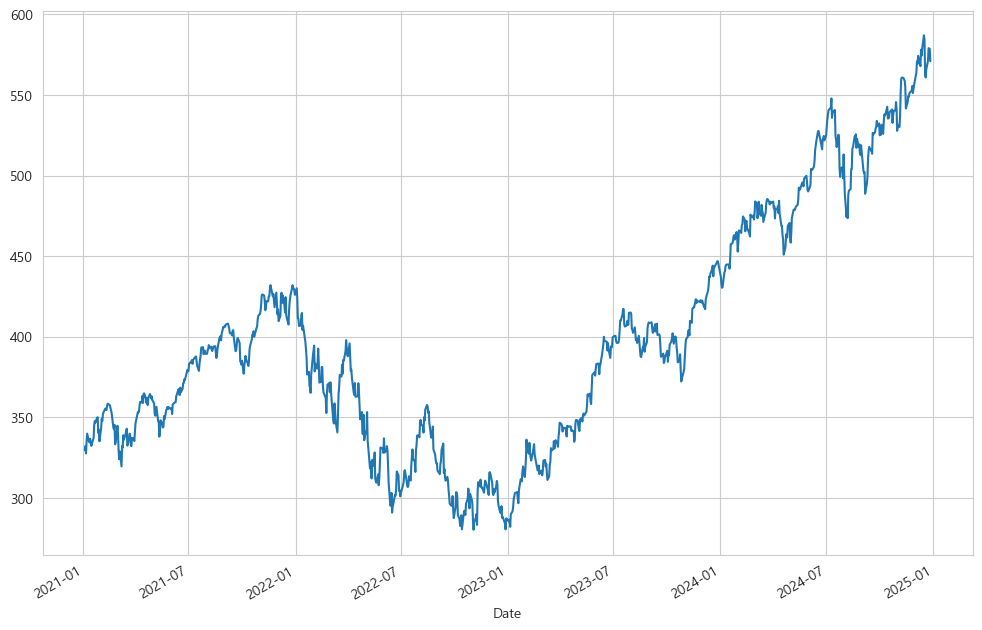

In [34]:
df_imp['QQQ']['2021':].plot()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


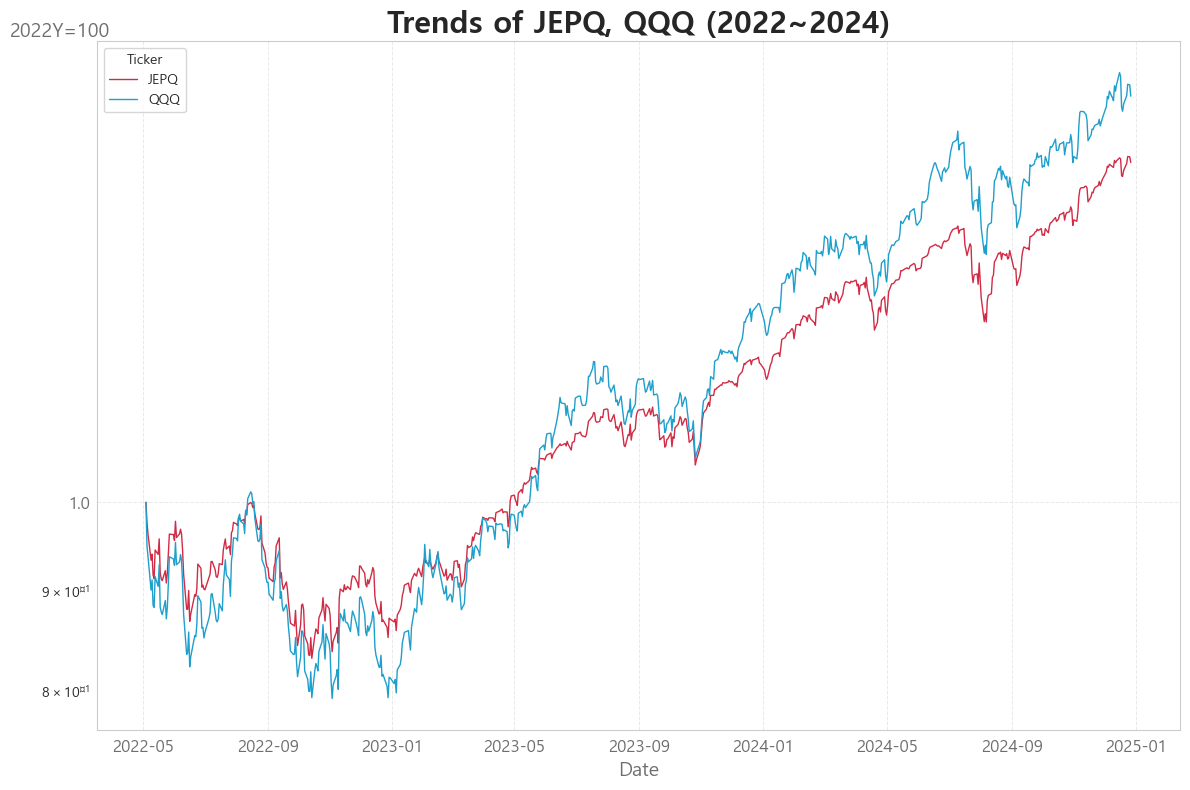

In [15]:
gm.trend_plot(plot_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

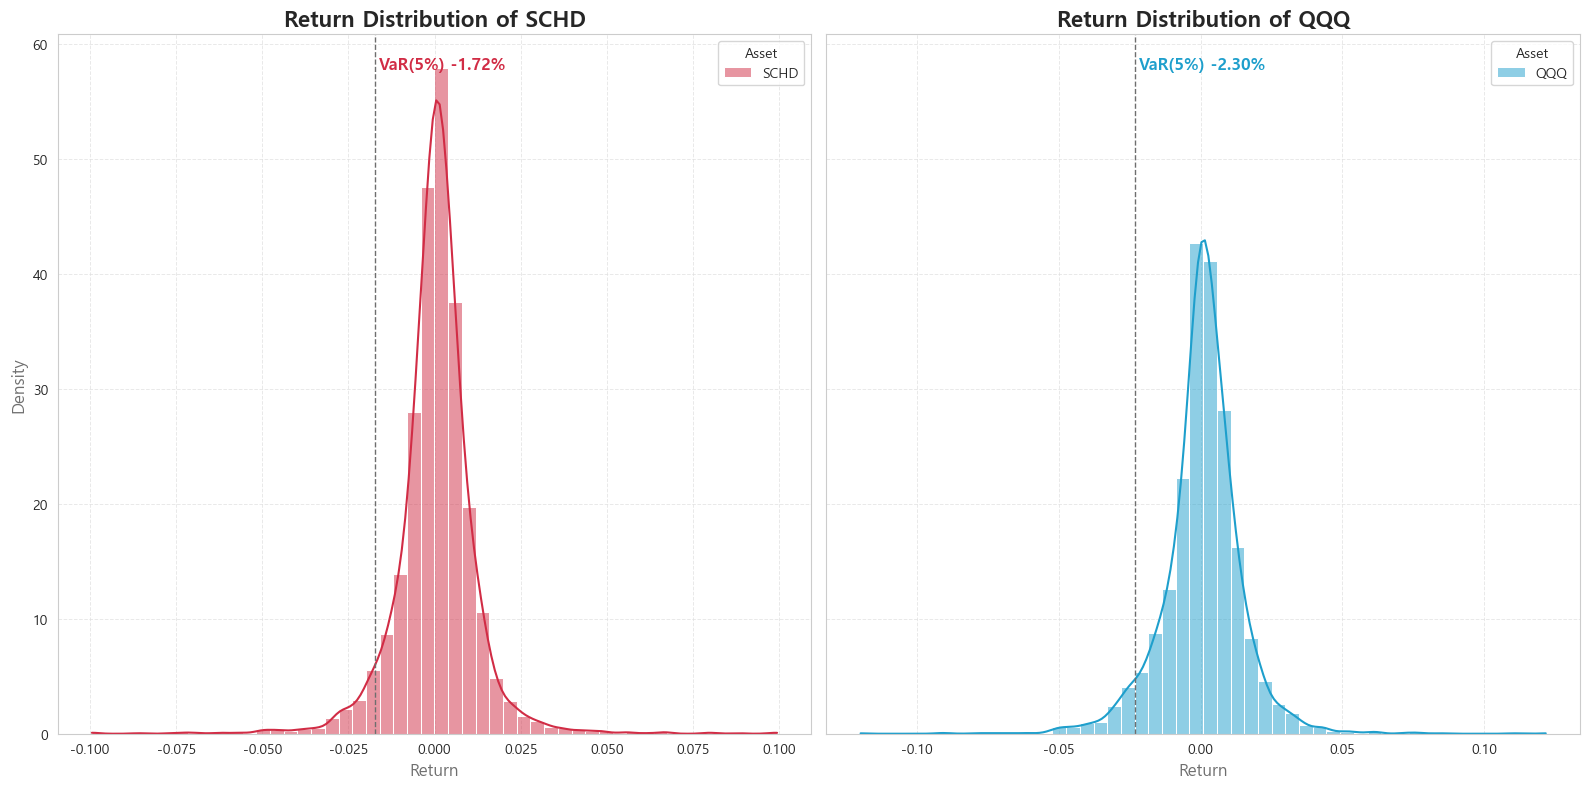

In [88]:
gm.asset_histogram_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

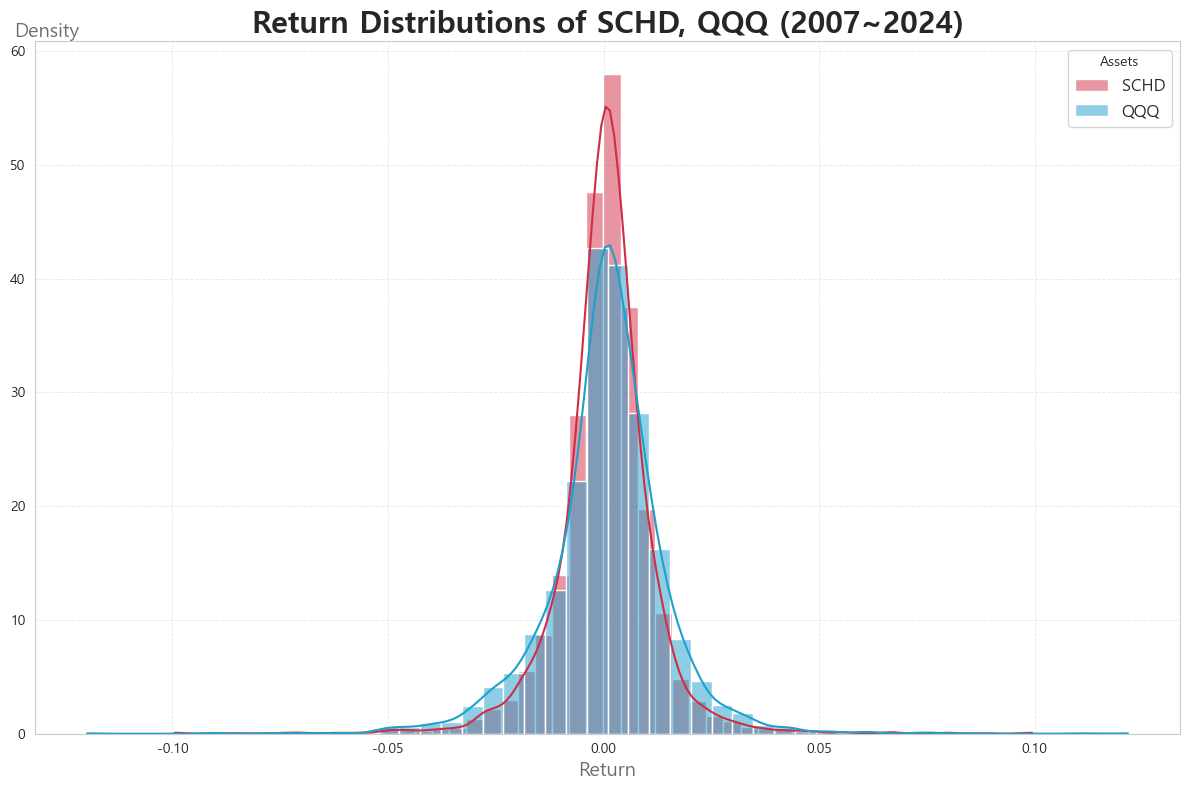

In [89]:
gm.asset_histogram_merged_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

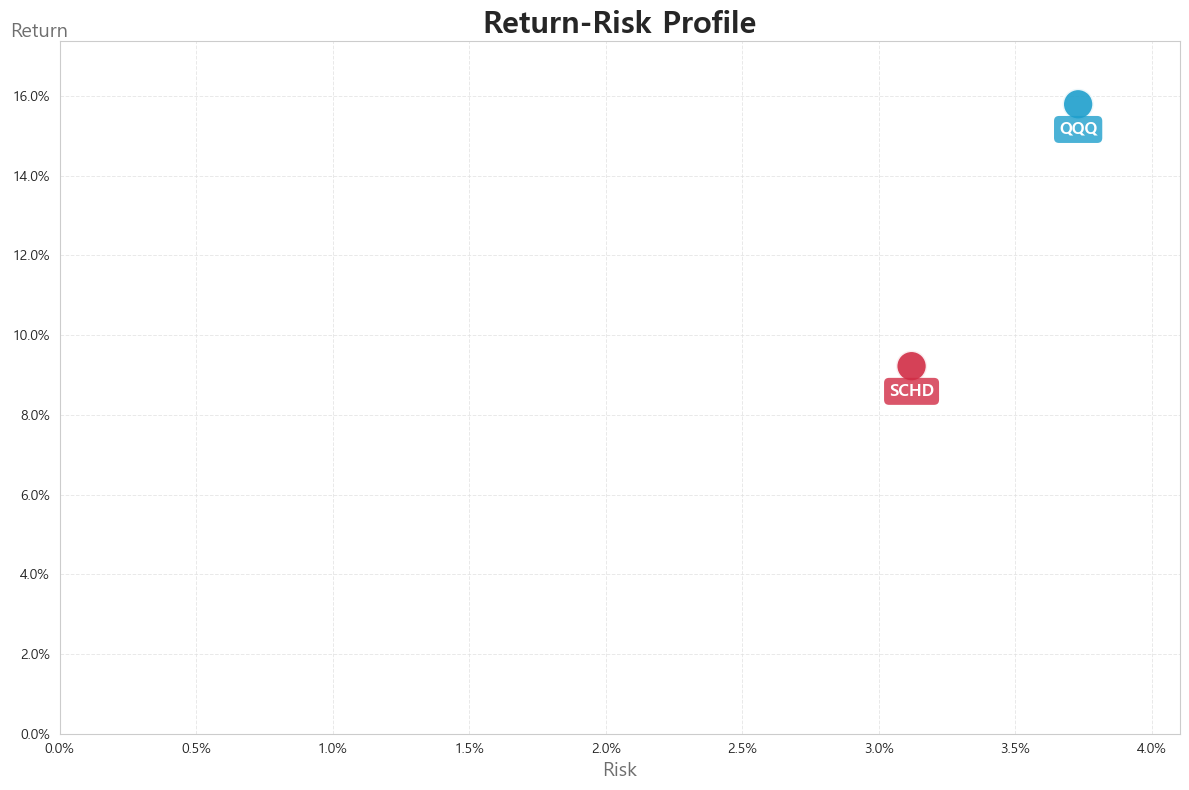

In [90]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

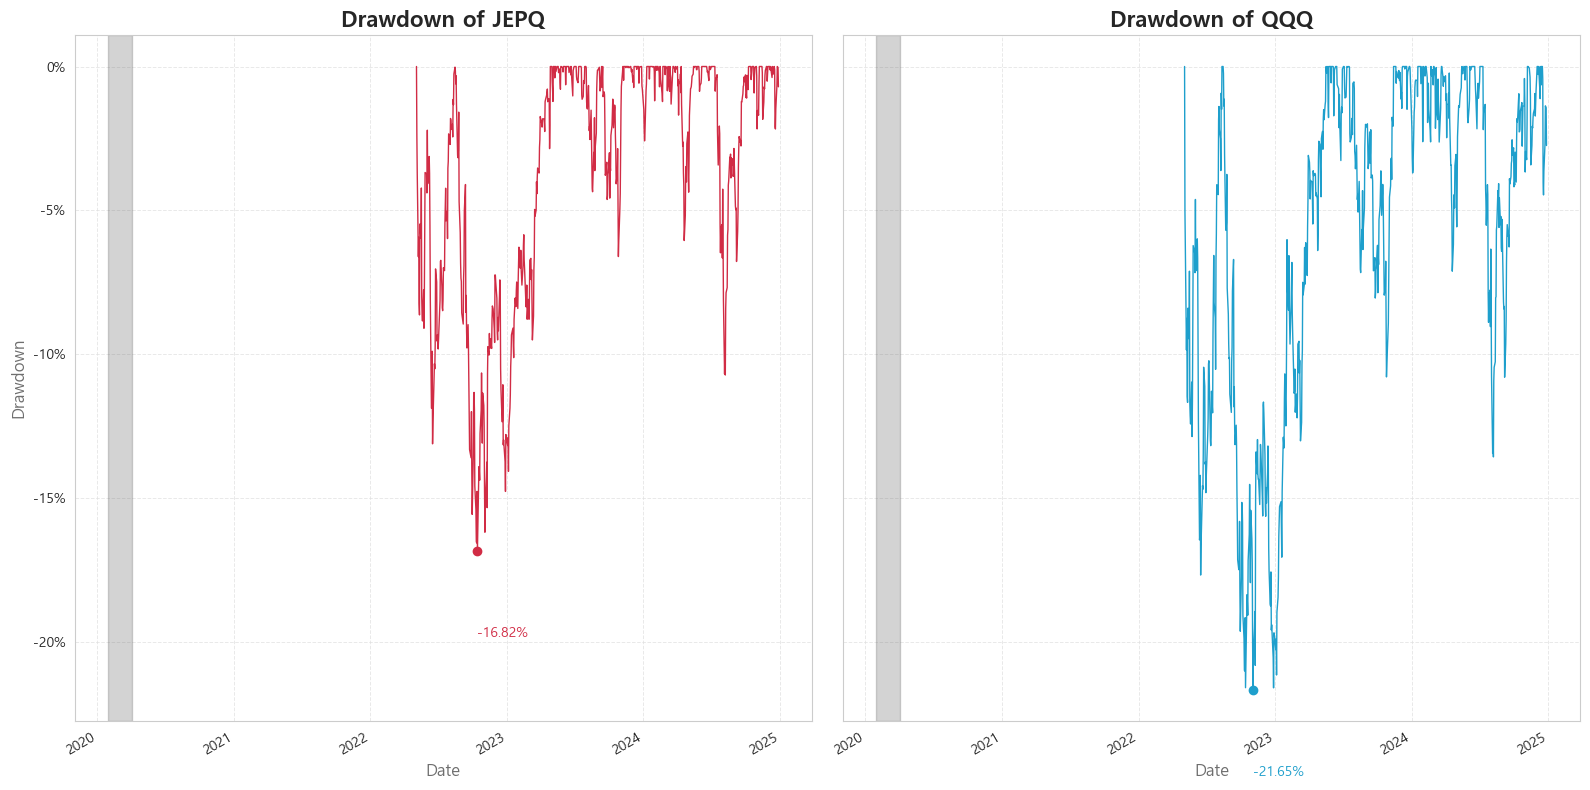

In [16]:
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

In [20]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

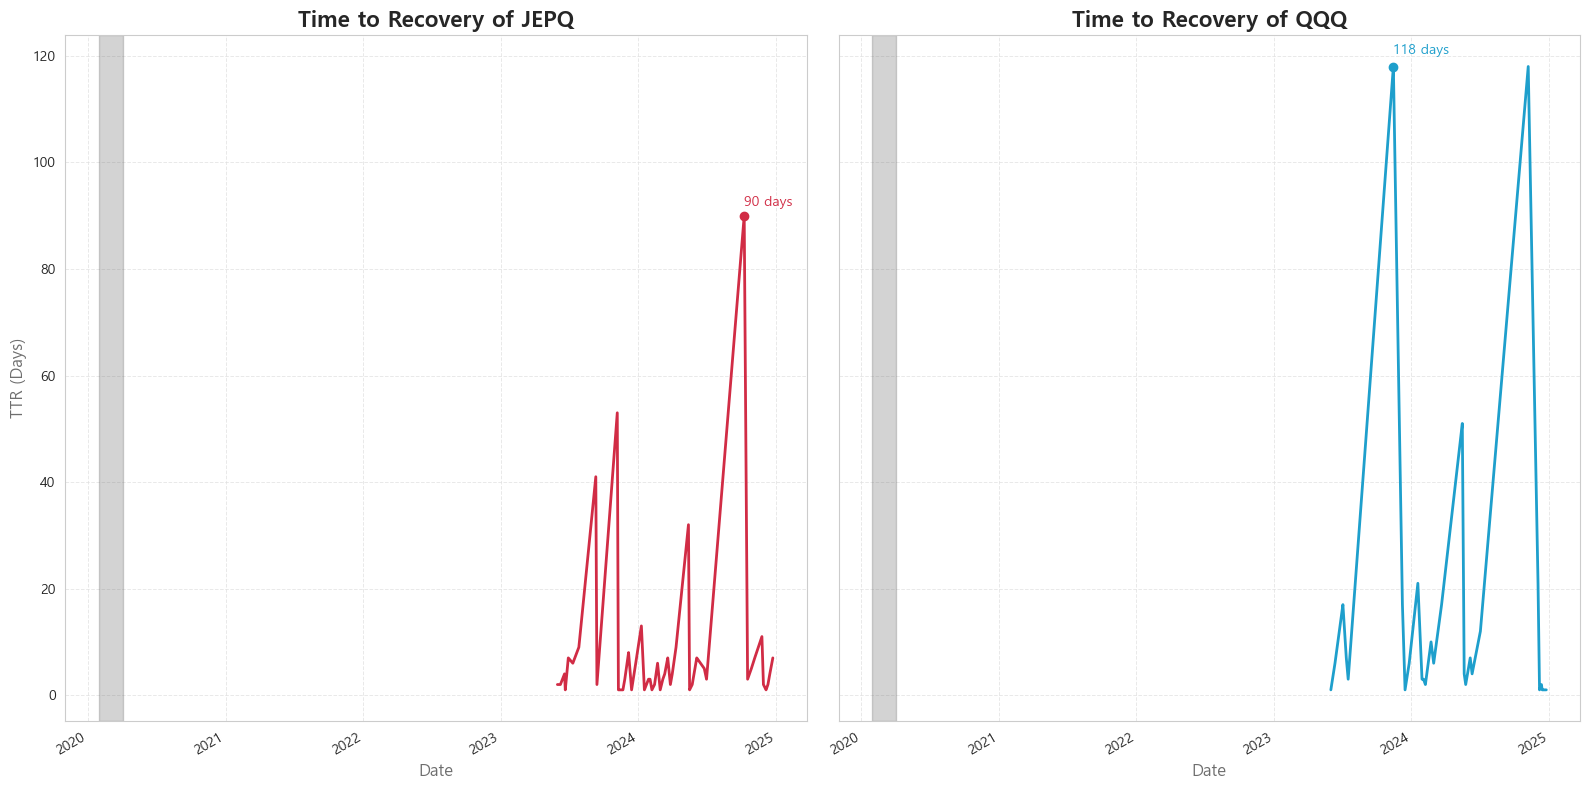

In [32]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df['2023-06':], assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

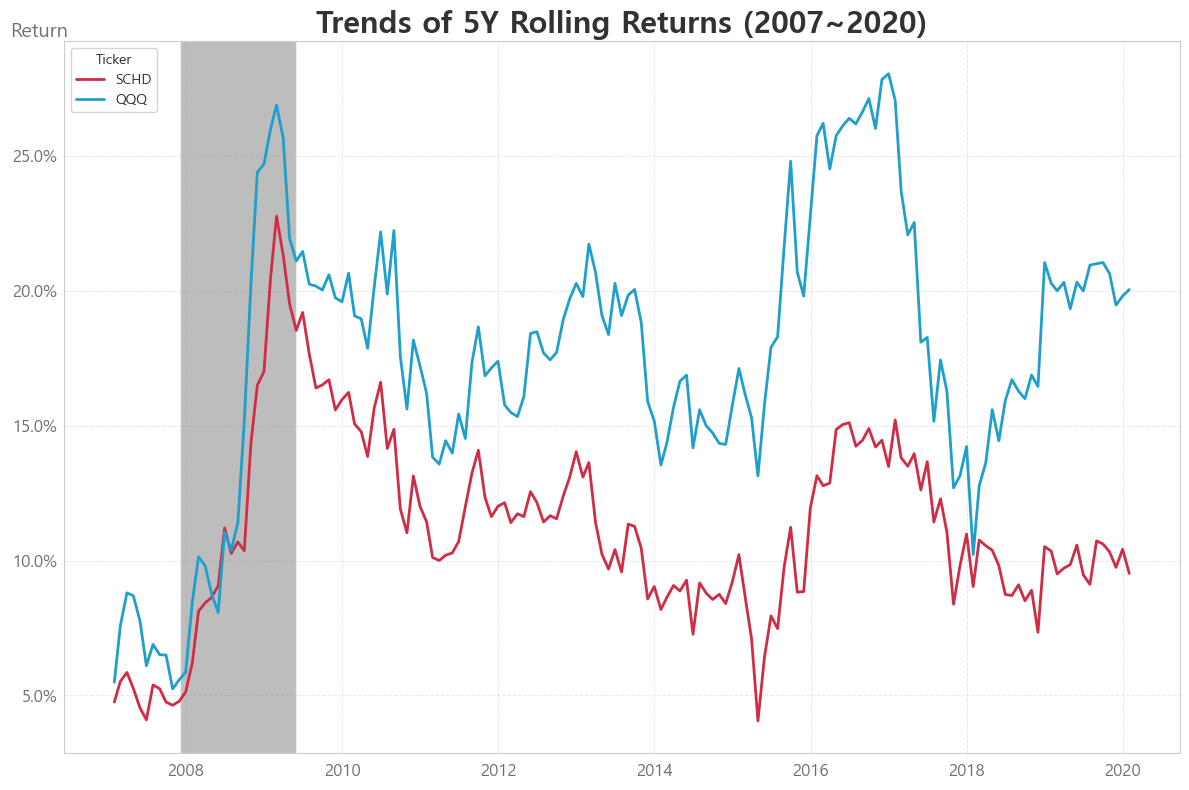

In [93]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

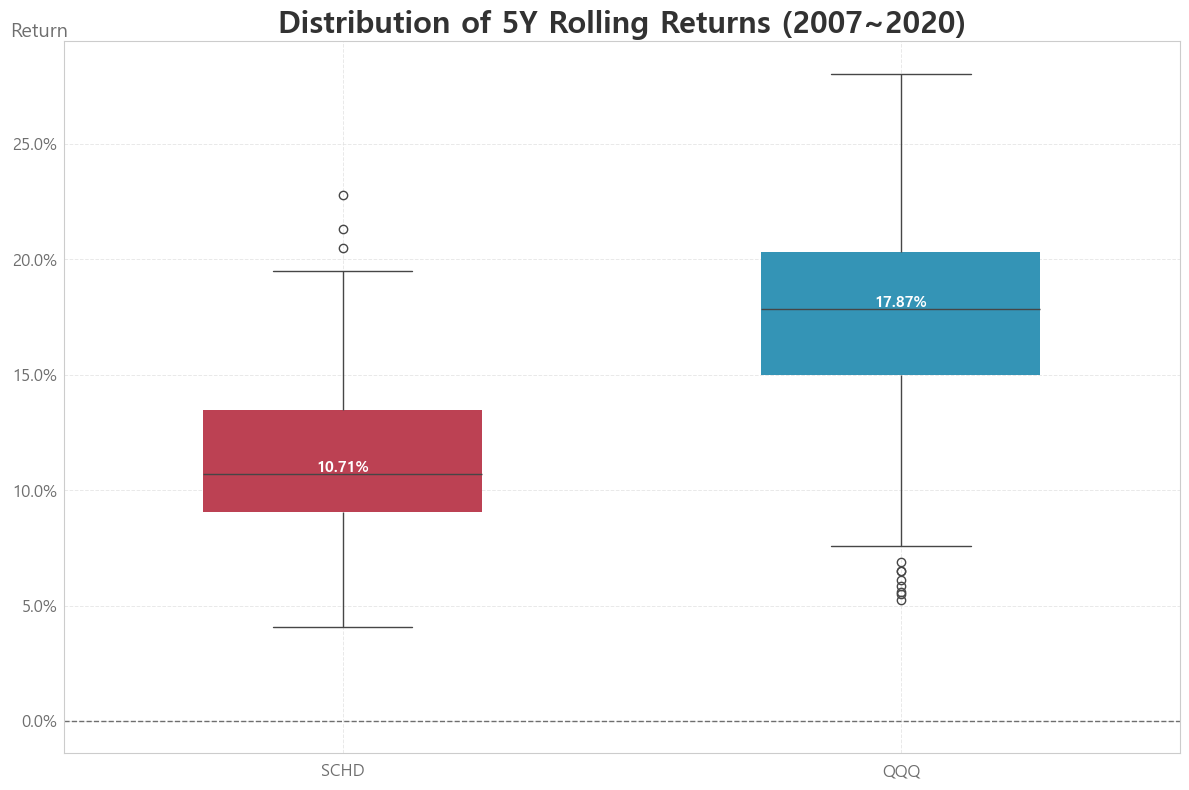

In [94]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [95]:
assets_port = assets + ['TLT', 'Gold']
assets_port = ['SCHD','QQQ']

In [96]:
def corr_plot(corr_df, cmap=None):
    # cmap이 None이면 기본 컬러맵 설정
    if cmap is None:
        custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
        cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

    # 히트맵 시각화
    plt.figure(figsize=figsize)
    sns.heatmap(corr_df, annot=True, cmap=cmap, fmt='.2f',
                linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 40})
    plt.title('Asset Correlations', fontsize=40, fontweight="bold", color=mycolors['color_basic'])
    plt.ylabel("Assets", fontsize=40, labelpad=-50, color=mycolors['color_around'], loc="top", rotation=0)
    plt.xlabel("")
    plt.yticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.xticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.tight_layout()
    plt.show()

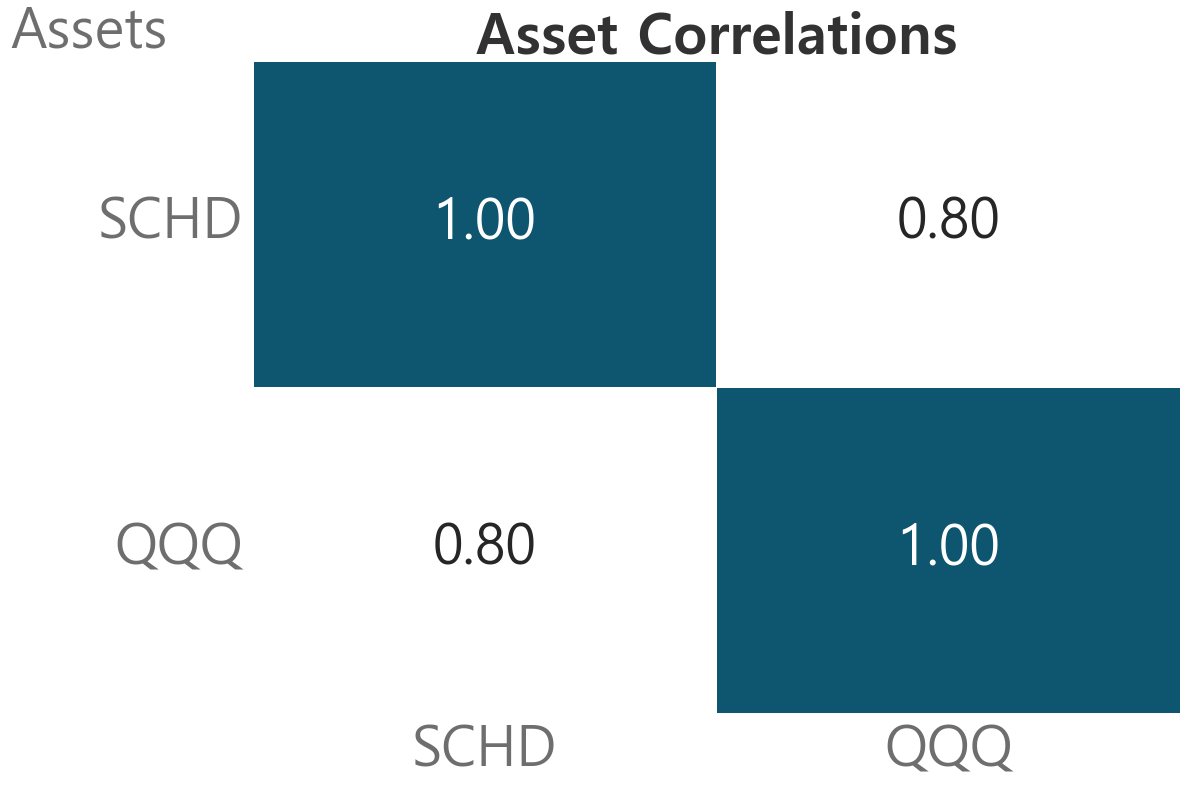

In [97]:
corr_df = plot_df.pct_change()[assets_port].corr()
corr_plot(corr_df, cmap=custom_cmap)

## Optimization

In [122]:
assets_port = ['SCHD', 'QQQ']
assets_port = ['SCHD', 'QQQ', 'TLT', 'Gold']

In [123]:
df_imp_m = plot_df[assets_port].resample('M').last()

In [124]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [125]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=10, min_edge=0)

총 286번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중


In [126]:
## process[process['Return'] > 11.30].sort_values('Sortino Ratio')

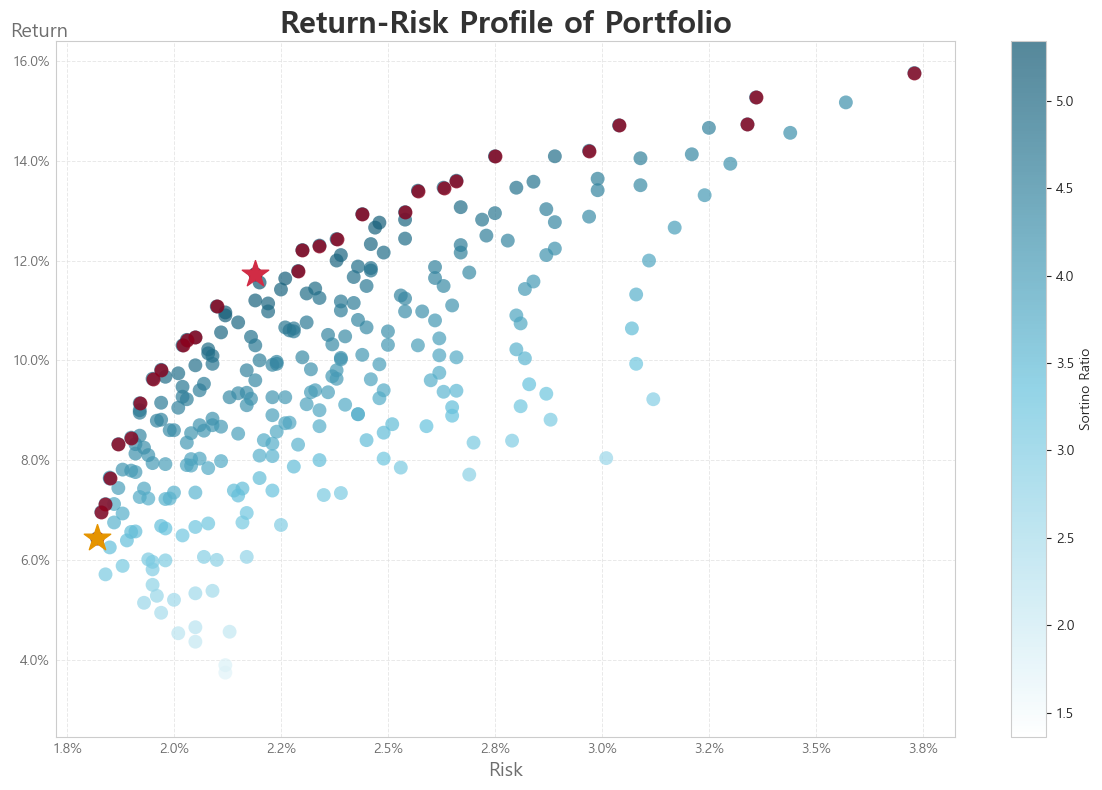

In [127]:
gm.portfilio_return_risk_profile_plot(process, obtimal, min_risk, cmap=custom_cmap)
# gm.portfilio_return_risk_profile_plot(process, min_risk, min_risk, cmap=custom_cmap)

In [129]:
min_risk

,SCHD,QQQ,TLT,Gold,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio,Point
0,0.2,0.0,0.5,0.3,6.43,2.94,1.82,2.19,3.54,MinRisk


In [164]:
process[process['Volatility(Down)'] <= 3.07].sort_values('Return')

,SCHD,QQQ,TLT,Gold,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio,Point,Efficient
10,0.0,0.0,1.0,0.0,3.08,4.14,2.27,0.74,1.36,None,False
9,0.0,0.0,0.9,0.1,3.74,3.88,2.12,0.96,1.76,None,False
75,0.1,0.0,0.9,0.0,3.89,3.72,2.12,1.05,1.83,None,False
8,0.0,0.0,0.8,0.2,4.36,3.69,2.05,1.18,2.13,None,False
74,0.1,0.0,0.8,0.1,4.53,3.47,2.01,1.31,2.26,None,False
...,...,...,...,...,...,...,...,...,...,...,...
62,0.0,0.8,0.2,0.0,13.64,4.35,2.99,3.13,4.56,None,False
115,0.1,0.7,0.0,0.2,14.09,4.30,2.89,3.28,4.88,None,False
56,0.0,0.7,0.0,0.3,14.09,4.15,2.75,3.39,5.13,None,True
61,0.0,0.8,0.1,0.1,14.20,4.39,2.97,3.23,4.77,None,True


In [157]:
## ratio 임의 조정시
ratio = [0, .8, 0.1, 0.1]
# ratio = [0.8, .2]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

In [158]:
port_assets = ['Portfolio'] + assets
port_assets_sp = ['Portfolio', 'SCHD', 'QQQ']

In [160]:
## ratio 임의 조정시
ratio = [0, .7, 0.15, 0.15]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
result.rename(columns={'strategy':'QQQ+TLT+Gold'}, inplace=True)
res1 = result/result.iloc[0]*100

## ratio 임의 조정시
ratio = [0.8, .2, 0, 0]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
result.rename(columns={'strategy':'SCHD+QQQ'}, inplace=True)
res2 = result/result.iloc[0]*100

res2['QQQ+TLT+Gold'] = res1['QQQ+TLT+Gold']
result = res2

In [161]:
last_cols = ['QQQ+TLT+Gold', 'SCHD+QQQ', 'SCHD' ,'QQQ']
last_cols_sp = ['QQQ+TLT+Gold', 'SCHD+QQQ']

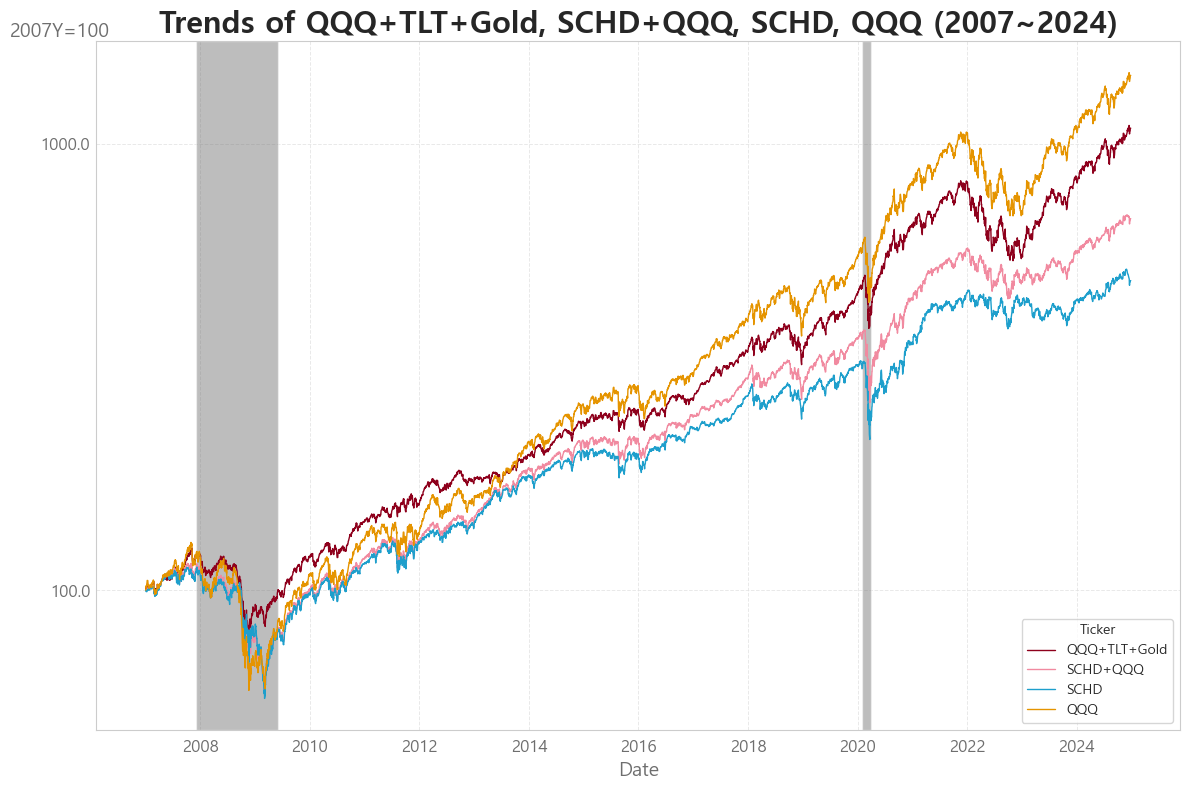

In [162]:
gm.trend_plot(result, last_cols, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_norm3'], mycolors['color_cont'], mycolors['color_sub']])

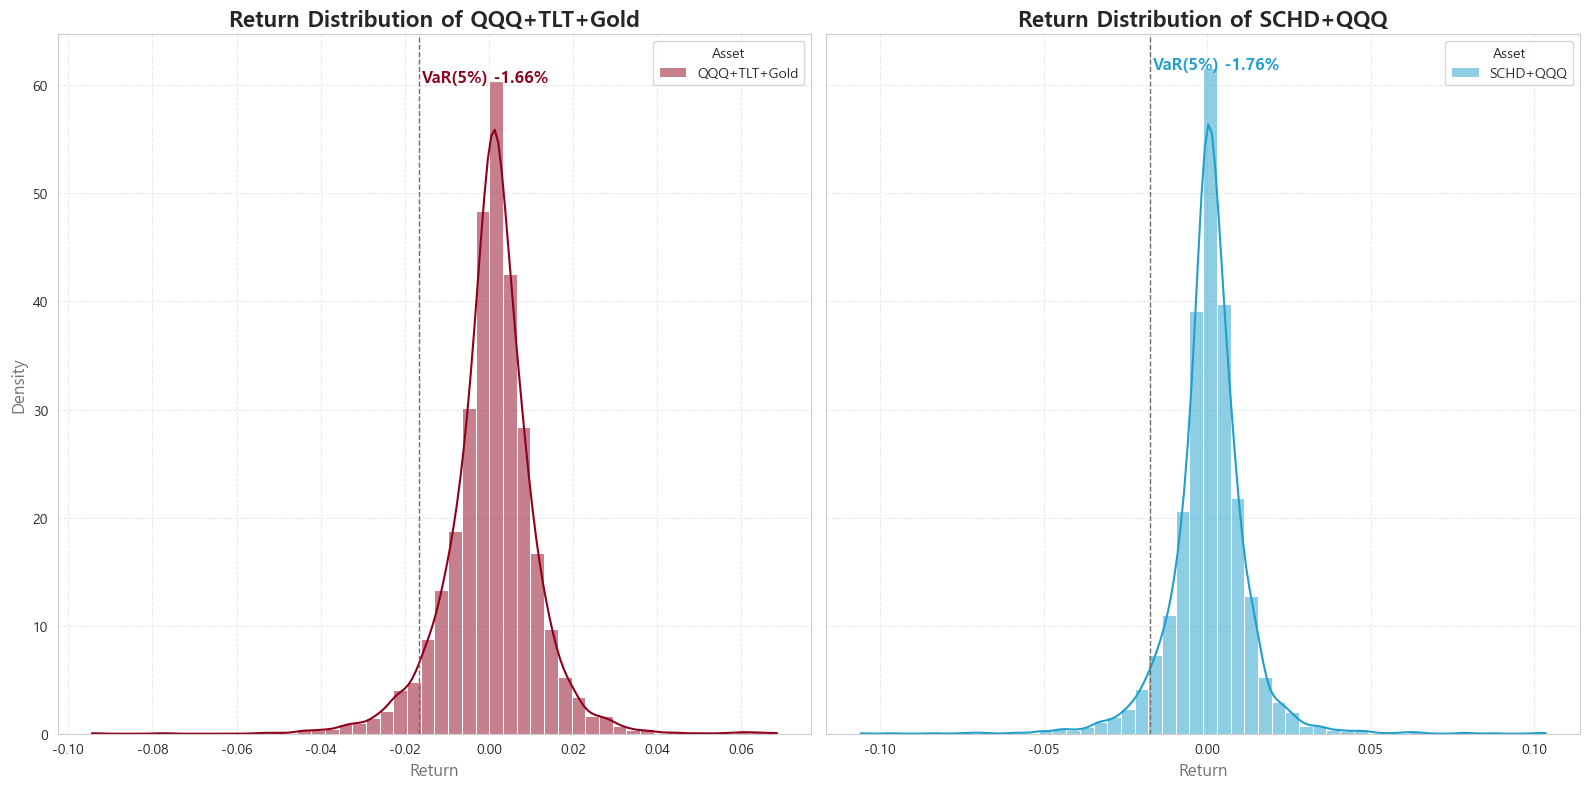

In [163]:
gm.asset_histogram_plot(result.pct_change(), last_cols_sp, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

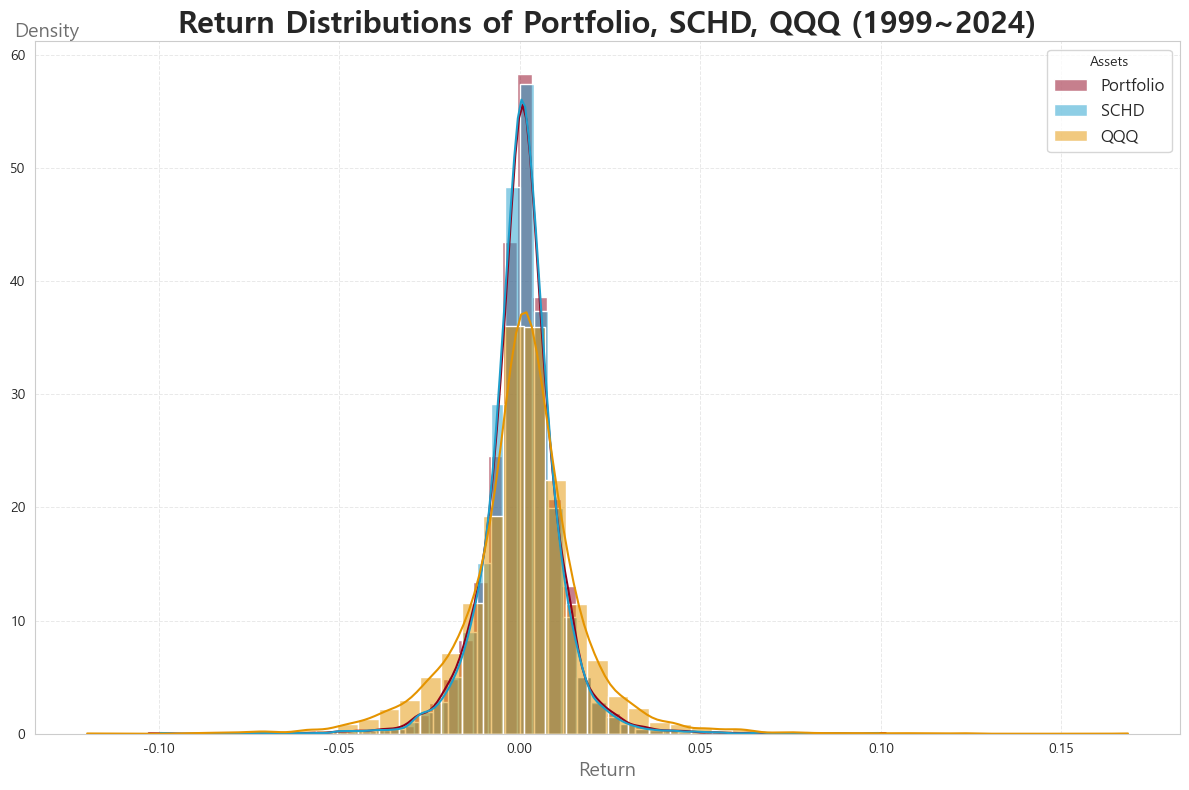

In [34]:
gm.asset_histogram_merged_plot(result.pct_change(), port_assets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

In [35]:
port_assets_sp

['Portfolio', 'SCHD', 'QQQ']

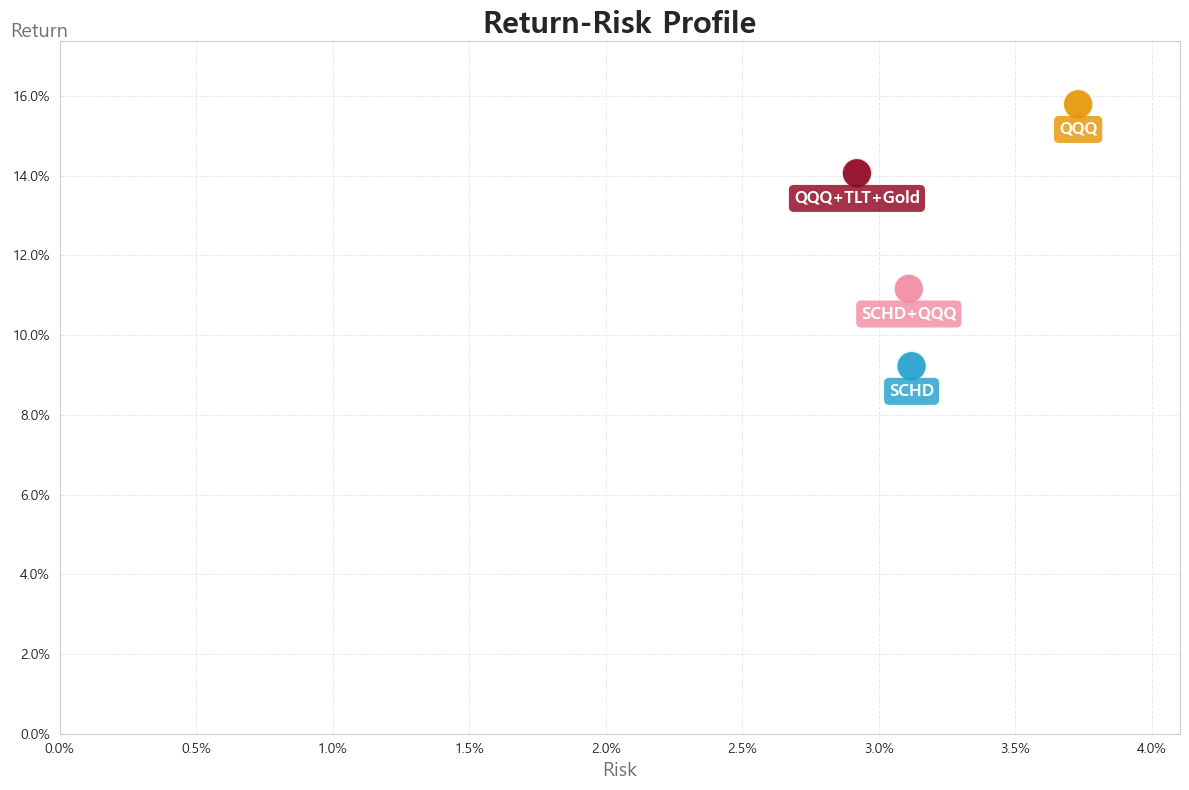

In [166]:
return_risk_df = anal_funcs.get_Vol_report(result[last_cols], unit='daily', method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, last_cols, colors=[mycolors['color_norm2'], mycolors['color_norm3'], mycolors['color_cont'], mycolors['color_sub']])

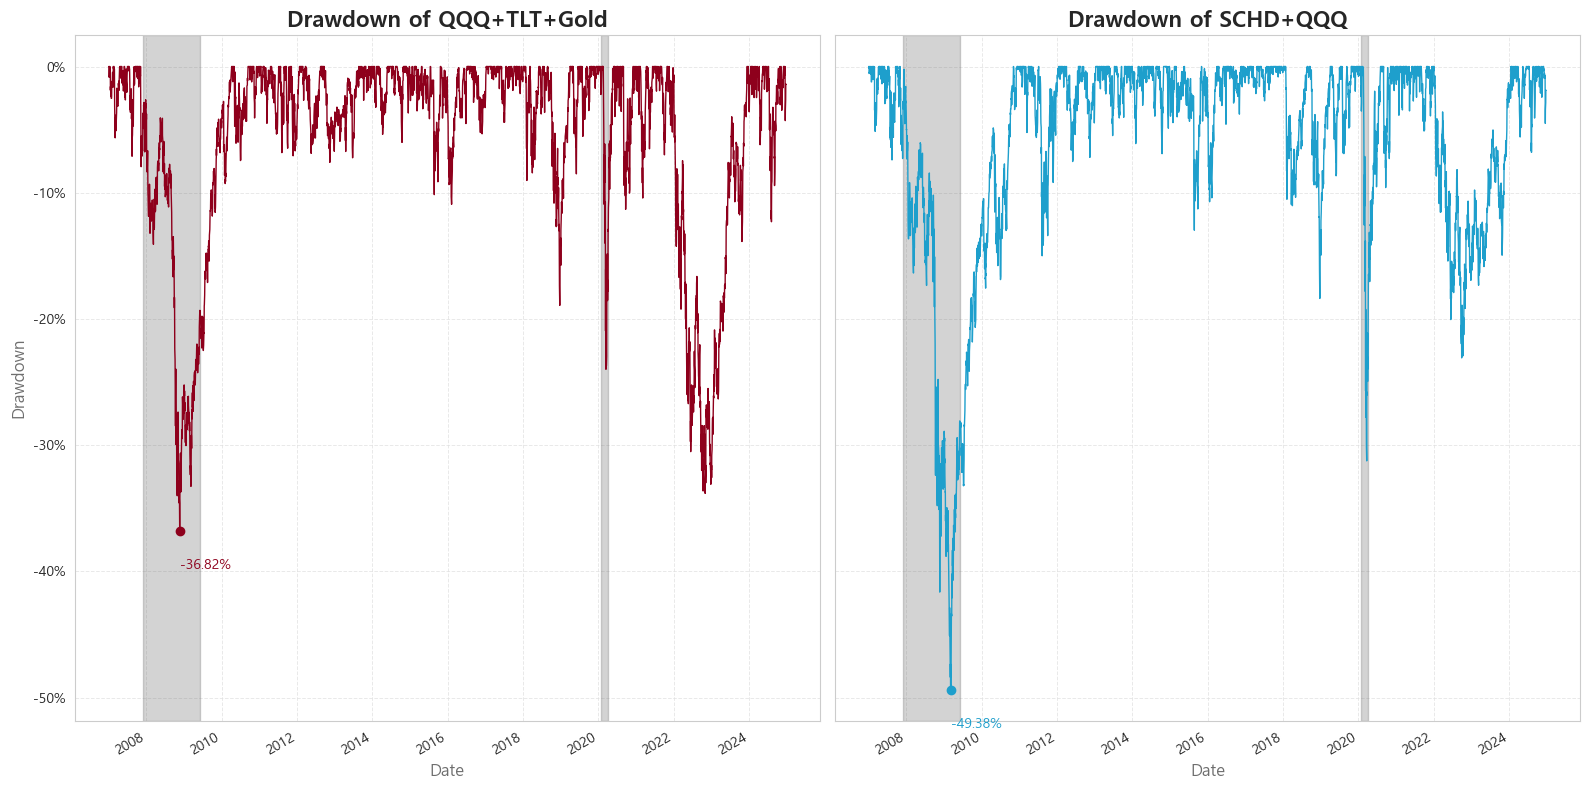

In [168]:
gm.drawdown_plot(result, last_cols_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

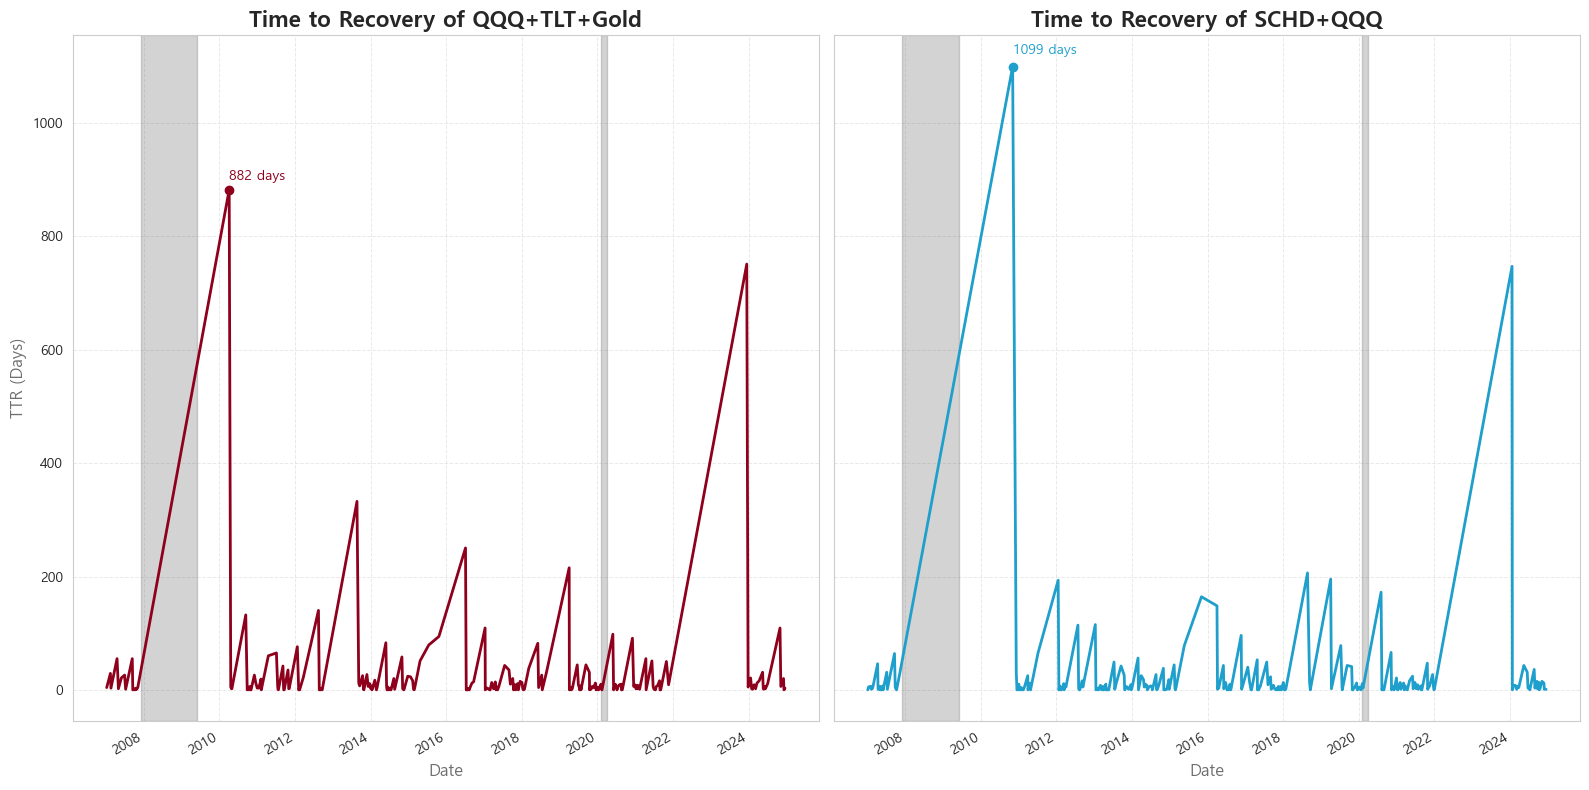

In [179]:
ttr_df = myfuncs.get_ttr_df(result, last_cols_sp)
gm.ttr_plot(ttr_df, last_cols_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

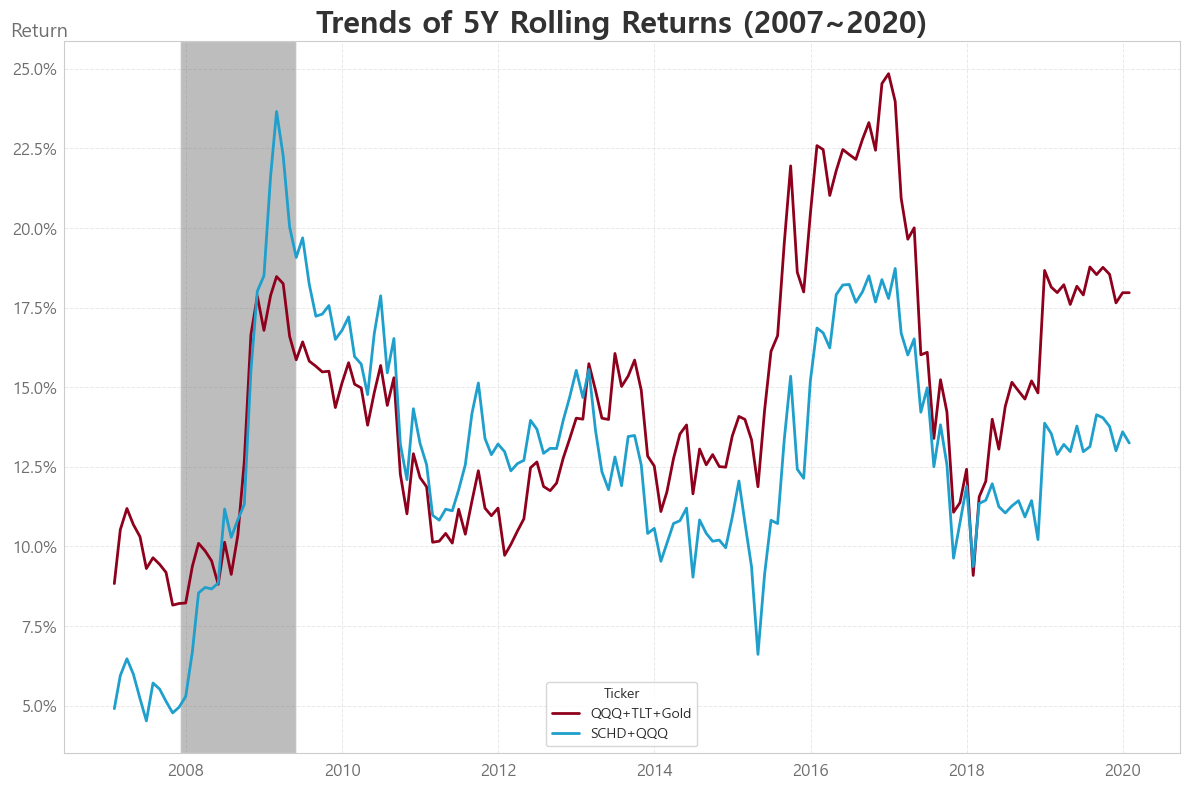

In [181]:
rr_df = myfuncs.get_rr_df(result, last_cols_sp)
gm.rr_trend_plot(rr_df, last_cols_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

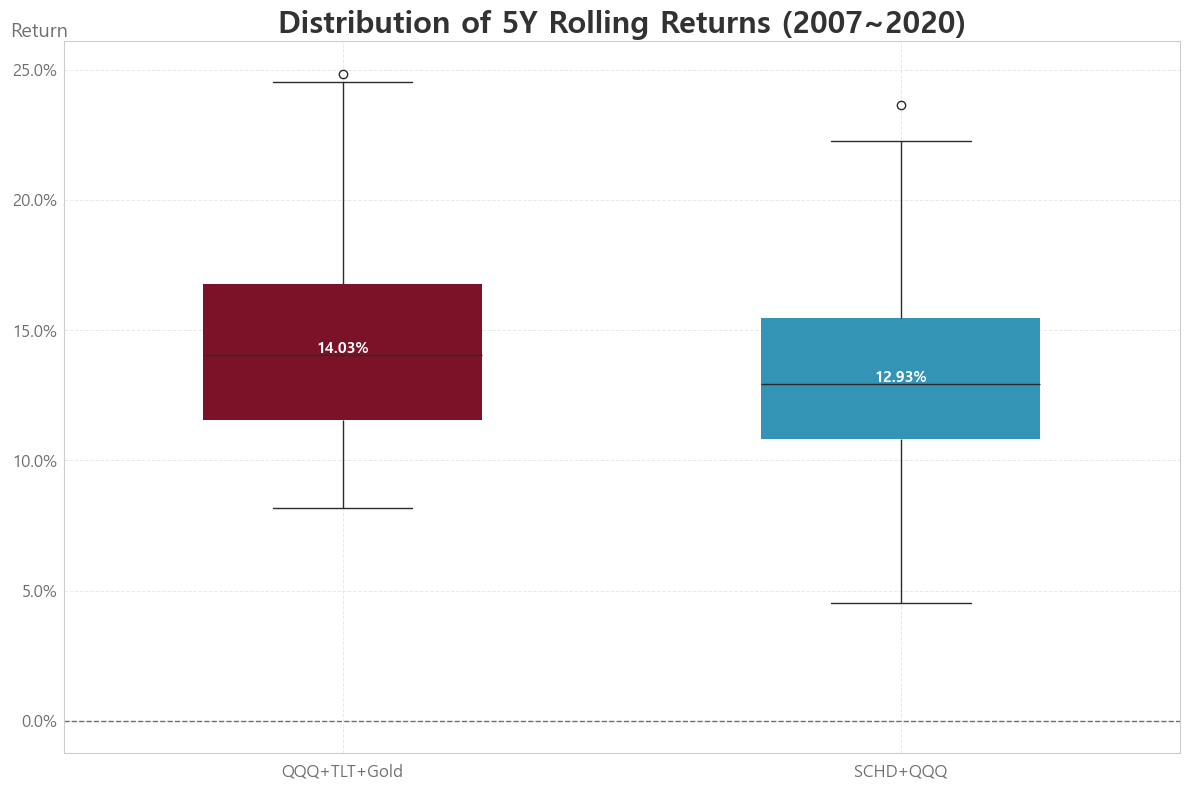

In [182]:
gm.rr_box_plot(rr_df, last_cols_sp, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

In [376]:
rr_df['Portfolio'].describe()

count    253.000000
mean      10.930173
std        4.497749
min       -1.963317
25%        7.355241
50%       11.277106
75%       13.593515
max       24.057869
Name: Portfolio, dtype: float64

In [377]:
rr_df['SCHD'].describe()

count    253.000000
mean      10.644312
std        4.034407
min       -1.476119
25%        8.486104
50%       10.770841
75%       13.374409
max       23.267830
Name: SCHD, dtype: float64

In [177]:
def corr_plot(corr_df, cmap=None):
    # cmap이 None이면 기본 컬러맵 설정
    if cmap is None:
        custom_colors = ["#F7FBFF", "#6BAED6", "#08256B"]
        cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

    # 히트맵 시각화
    plt.figure(figsize=figsize)
    sns.heatmap(corr_df, annot=True, cmap=cmap, fmt='.2f',
                linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 25})
    plt.title('Asset Correlations', fontsize=25, fontweight="bold", color=mycolors['color_basic'])
    plt.ylabel("Assets", fontsize=25, labelpad=-50, color=mycolors['color_around'], loc="top", rotation=0)
    plt.xlabel("")
    plt.yticks(rotation=0, fontsize=25, color=mycolors['color_around'])
    plt.xticks(rotation=0, fontsize=25, color=mycolors['color_around'])
    plt.tight_layout()
    plt.show()

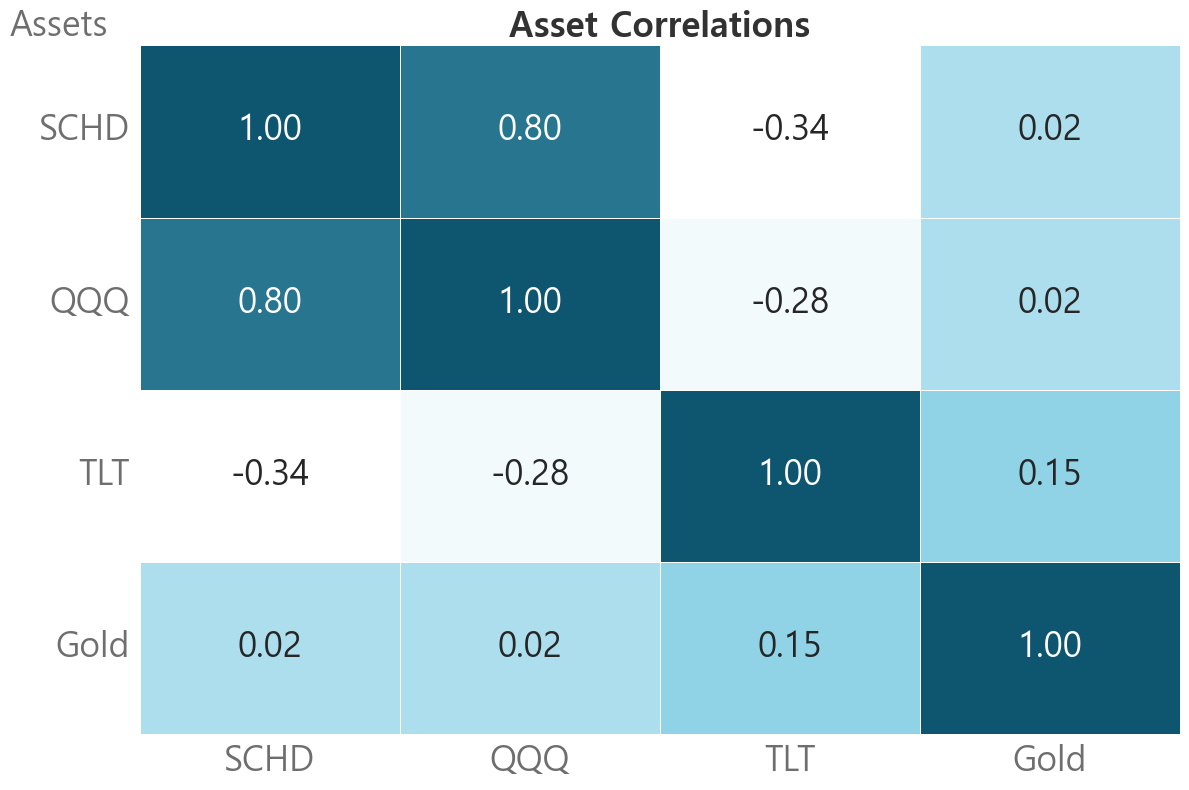

In [178]:
corr_df = plot_df[['QQQ', 'SCHD', 'TLT', 'Gold']].pct_change()[assets_port].corr()
corr_plot(corr_df, cmap=custom_cmap)

['QQQ+TLT+Gold', 'SCHD+QQQ', 'SCHD', 'QQQ']